# Pharmacy TSNE Visualization

In [4]:
import pandas as pd
import numpy as np

# Local libraries should automatically reload
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read from input table

We read from the **patient_sv** table containing a 10 dimensional vector for each patient.

In [6]:
%aimport gpudb_df

# load input table
_table_df = gpudb_df.load_df('PATIENT_U_VEC')
_table_df.head()

Getting records from <PATIENT_U_VEC>..
Records Retrieved: (19092, 11)


,PATIENT_ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,3,-0.026869,0.003544,0.067632,0.007149,0.019579,-0.012598,0.039725,0.012359,-0.002720,0.005420
1,4,-1.025537,-0.915222,-0.135088,0.506937,-0.046075,-0.790646,-0.736051,-0.174529,-0.203942,-0.047053
2,6,-0.835222,-0.685774,-0.319621,-0.053120,0.135096,0.106425,0.025238,-0.039275,-0.001030,-0.026680
3,7,-0.465780,-0.495243,-0.087060,0.222816,0.009257,-0.530207,-0.575800,-0.017807,-0.002585,0.176052
4,9,-0.065967,0.046649,0.009301,0.070871,-0.131696,-0.014793,-0.015506,-0.036466,0.100262,-0.003387


### Calculate K-Means

In [7]:
from sklearn.cluster import KMeans

# convert to numpty matrix
_table_np = _table_df.iloc[:,1:].values.astype(np.float64)
print('Input patient vectors: ', _table_np.shape)

PAT_CLUSTERS = 6
_pat_means = KMeans(n_clusters=PAT_CLUSTERS, 
                    random_state=0).fit(_table_np)

print('K-means clusters: ', _pat_means.cluster_centers_.shape)
print('K-means labels: ', _pat_means.labels_.shape)

Input patient vectors:  (19092, 10)
K-means clusters:  (6, 10)
K-means labels:  (19092,)


### Create a combined dataframe of counts and means

In [8]:
# get counts of means
_labels_df = pd.DataFrame(_pat_means.labels_, columns=['IDX'])
_counts_df = pd.DataFrame(_labels_df.groupby('IDX').size(), columns=['COUNT'])

# create a dataframe of centroids
_centroids_df = pd.DataFrame(_pat_means.cluster_centers_, 
                             columns=_table_df.columns[1:],
                             index=_counts_df.index)

# create a combined dataframe
_means_df = pd.concat([_counts_df, _centroids_df], axis=1)
_means_df

,COUNT,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9
IDX,,,,,,,,,,,
0,17066,-0.027381,0.011948,0.009277,0.028651,0.008627,0.007250,0.005802,0.004578,0.000861,-0.009877
1,723,-0.315924,0.372343,-0.144270,-0.126296,0.227225,-0.052531,-0.013767,-0.022696,0.004067,-0.010314
2,132,-0.597413,0.014181,1.120111,-0.411596,-0.003652,0.105453,-0.063343,0.010559,-0.006784,0.020970
3,815,-0.268761,0.252776,-0.054790,0.046236,-0.284102,0.045891,0.039550,0.015015,-0.029403,0.031381
4,270,-0.821194,-0.668013,-0.263128,-0.066257,0.018686,0.083977,0.050015,0.003429,-0.005255,-0.003538
5,86,-0.516344,-0.085217,0.134201,0.605587,-0.038393,-0.738047,-0.712726,-0.010521,0.009624,0.139909


### Save k-means table to Kinetica

In [9]:
%aimport gpudb_df

gpudb_df.save_df(_means_df, 'PATIENT_KMEANS')

Dropping table: <PATIENT_KMEANS>
Creating table: <PATIENT_KMEANS>
Column 0: <IDX> (long)
Column 1: <COUNT> (long)
Column 2: <v0> (double)
Column 3: <v1> (double)
Column 4: <v2> (double)
Column 5: <v3> (double)
Column 6: <v4> (double)
Column 7: <v5> (double)
Column 8: <v6> (double)
Column 9: <v7> (double)
Column 10: <v8> (double)
Column 11: <v9> (double)
Inserted rows into <PHARMACY.PATIENT_KMEANS>: 6


### Generate labels for centroids

The of the t-SNE plot need to be determined manually from the drug ratings for each centriod.

The below SQL will generate 4 approximations for a centroid. This should be run for each cluster.

In [10]:
%aimport gpudb_df
_cnxn = gpudb_df.get_odbc()

_sql = """
select top 4
    pv.idx,
    dv.tid,
    pv.count,
    d.generic_name,
    (pv.v0 * dv.v0)
    + (pv.v1 * dv.v1) 
    + (pv.v2 * dv.v2) 
    + (pv.v3 * dv.v3) 
    + (pv.v4 * dv.v4) 
    + (pv.v5 * dv.v5) 
    + (pv.v6 * dv.v6) 
    + (pv.v7 * dv.v7) 
    + (pv.v8 * dv.v8) 
    + (pv.v9 * dv.v9) 
    as DRUG_RATING
from PATIENT_KMEANS as pv, DRUG_V_VEC as dv
join DRUG_TID as d
    ON dv.TID = d.TID
where pv.idx = {}
order by drug_rating desc
"""

_final_df = pd.DataFrame()

for _idx in _means_df.index.values:
    _new_sql = _sql.format(_idx)
    print('Calculating index: {}'.format(_idx))
    _rows_df = pd.read_sql(_new_sql, _cnxn)
    _final_df = _final_df.append(_rows_df)

_cnxn.close()

_final_df = _final_df.set_index(['IDX','TID'])
_final_df

Connected to GPUdb ODBC Server (6.2.0.9.20180622232941)
Calculating index: 0
Calculating index: 1
Calculating index: 2
Calculating index: 3
Calculating index: 4
Calculating index: 5


COUNT                  GENERIC_NAME  DRUG_RATING
IDX TID                                                   
0   5970  17066  PIRBUTEROL ACETATE BREATH AC     0.380226
    301   17066  TRIAMCINOLONE ACETONIDE NASA     0.247450
    2747  17066         SIMVASTATIN TAB 80 MG     0.228387
    649   17066  TIZANIDINE HCL TAB 4 MG (BAS     0.202541
1   2747    723         SIMVASTATIN TAB 80 MG     5.769378
    156     723  METFORMIN HCL TAB SR 24HR MO     4.981999
    3510    723      GLUCOSE BLOOD TEST STRIP     4.245050
    2578    723        TOLBUTAMIDE TAB 500 MG     3.767242
2   583     132  TRAMADOL HCL TAB ER 24HR BIP    22.688260
    6637    132  HYDROCODONE-ACETAMINOPHEN TA     4.558854
    649     132  TIZANIDINE HCL TAB 4 MG (BAS     4.076785
    2747    132         SIMVASTATIN TAB 80 MG     2.837303
3   2747    815         SIMVASTATIN TAB 80 MG     5.952790
    2530    815  NEBIVOLOL HCL TAB 5 MG (BASE     4.478772
    4609    815   NISOLDIPINE TAB ER 24HR 8.5     1.901620
    225     815           VALSARTAN TAB 80 MG     1.647178
4   6637    270  HYDROCODONE-ACETAMINOPHEN TA    22.381689
    649     270  TIZANIDINE HCL TAB 4 MG (BAS     2.737316
    2747    270         SIMVASTATIN TAB 80 MG     2.412181
    6030    270      PREGABALIN SOLN 20 MG/ML     1.977038
5   523      86            OXAZEPAM CAP 30 MG    17.382263
    530      86      SERTRALINE HCL TAB 50 MG     6.154036
    6637     86  HYDROCODONE-ACETAMINOPHEN TA     6.088005
    5970     86  PIRBUTEROL ACETATE BREATH AC     3.054193

### Manually entered labels for the clusters

(These need to be updated after running on a new data set)

In [15]:
_cbar_labels = [ 
    'Generic "other"',
    'Diabetic + high cholesterol',
    'Tramadol (opiate)',
    'Cholesterol + high blood pressure',
    'Hydrocodone (opiate)',
    'Opiate + muscle relaxant' ]

### 2D t-SNE Visualization

t-distributed Stochastic Neighbor Embedding

In [16]:
from sklearn.manifold import TSNE

# This algorithm is slow so we only use the first N points.
TSNE_POINTS = 1000

tsne_2d = TSNE(
    n_components=2, 
    verbose=1, 
    #perplexity=80, 
    #n_iter=600, 
    random_state=0
)

tsne_2d_results = tsne_2d.fit_transform(_table_np[:TSNE_POINTS])
print('Done', tsne_2d_results.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.004191
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.831093
[t-SNE] Error after 1000 iterations: 0.658938
Done (1000, 2)


### Plot t-SNE results with cluster labels

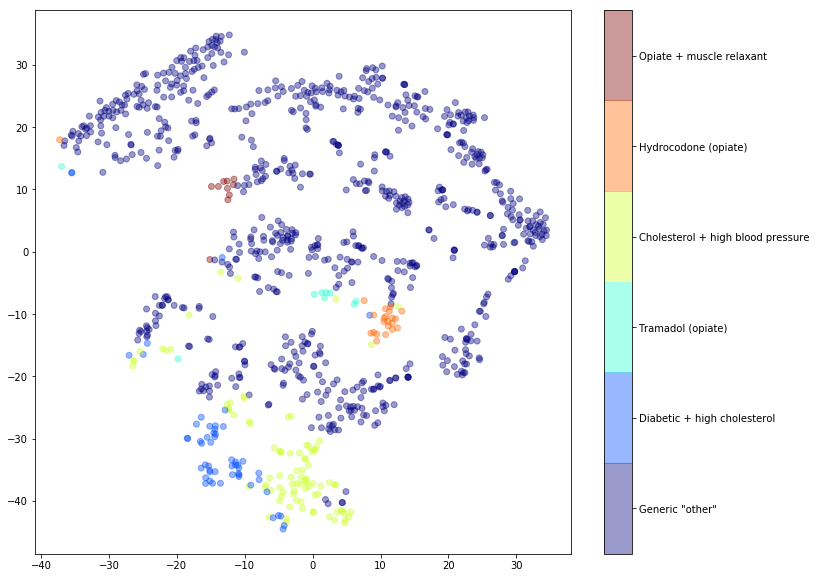

In [17]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,10))
sc = plt.scatter(
    x=tsne_2d_results[:,1],
    y=tsne_2d_results[:,0], 
    c=_pat_means.labels_[:TSNE_POINTS], 
    alpha=0.4, 
    cmap=plt.cm.get_cmap("jet", PAT_CLUSTERS)
)
plt.clim(-0.5, PAT_CLUSTERS - 0.5)
cbar = plt.colorbar(sc)
cbar.ax.set_yticklabels(_cbar_labels)
plt.show()

### 3D t-SNE Visualization

In [18]:
from sklearn.manifold import TSNE
TSNE_3D_POINTS = 1000

tsne_3d = TSNE(
    n_components=3, 
    verbose=1, 
    #perplexity=80, 
    #n_iter=600, 
    random_state=0
)
tsne_3d_results = tsne_3d.fit_transform(_table_np[:TSNE_3D_POINTS])
print('Done', tsne_3d_results.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.004191
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.757591
[t-SNE] Error after 1000 iterations: 0.528360
Done (1000, 3)


In [19]:
import plotly as pt

pt.tools.set_credentials_file(username='chadj', api_key='FbXuRiU8xILD5J1MbyzR')
#pt.offline.init_notebook_mode(connected=True)

scatter_3d = pt.graph_objs.Scatter3d(
    x=tsne_3d_results[:,0],
    y=tsne_3d_results[:,1],
    z=tsne_3d_results[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=_pat_means.labels_[:TSNE_3D_POINTS],
        colorscale='Viridis',
        opacity=0.5,
        showscale=True,
        colorbar=dict( 
            ticks='outside'
        )
    )
)

scatter_fig = pt.graph_objs.Figure(
    data=[scatter_3d], 
    layout=pt.graph_objs.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
)

pt.plotly.iplot(scatter_fig, filename='svd-tsne-3d')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~chadj/0 or inside your plot.ly account where it is named 'svd-tsne-3d'
